In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import visual_behavior.visualization.utils as ut
import visual_behavior.data_access.loading as loading
import visual_behavior.visualization.ophys.summary_figures as sf 
import visual_behavior.ophys.response_analysis.utilities as utilities
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis

### get multi session dataframe for images and omissions for [0.5, 0.75] second window around stim or omission 

In [4]:
experiments_table = loading.get_filtered_ophys_experiment_table() 

In [5]:
cache_dir = loading.get_analysis_cache_dir()

df_name = 'stimulus_response_df' 
#df is also separated into running/not running & engaged/disengaged
conditions = ['cell_specimen_id', 'omitted', 'running', 'engagement_state'] 
project_codes = ['VisualBehaviorMultiscope']
experiments = experiments_table[experiments_table.project_code.isin(project_codes)]

multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments)

In [6]:
multi_session_df.head()

,cell_specimen_id,omitted,running,engagement_state,mean_response,sem_response,mean_trace,sem_trace,mean_responses,mean_baseline,...,cre_line,location,location_layer,layer,ophys_session_id,project_code,specimen_id,depth,exposure_number,container_id
0,1028781348,False,False,disengaged,0.000721,0.012926,"[0.010714817623748492, -0.015553198870146875, ...","[0.016210924424433677, 0.011715060985254632, 0...","[0.03334277908923048, -0.044772088049694986, 0...",-0.017716,...,Slc17a7-IRES2-Cre,Excitatory deep,Slc17a7_VISp_L5b,L5b,903621170,VisualBehaviorMultiscope,840390377,deep,0,1018027884
1,1028781348,False,False,engaged,-0.002152,0.000860,"[0.00519929508255134, -0.005588935948057038, -...","[0.0018585368018670754, 0.0017810281266605877,...","[0.02514257088226257, 0.02217992179272731, 0.0...",-0.005847,...,Slc17a7-IRES2-Cre,Excitatory deep,Slc17a7_VISp_L5b,L5b,903621170,VisualBehaviorMultiscope,840390377,deep,0,1018027884
2,1028781348,False,True,disengaged,0.002939,0.000643,"[0.005031588584506801, 0.002731572393388378, -...","[0.001464543214568269, 0.001469382753917812, 0...","[0.0022867141998144367, -0.0073170566663133705...",-0.000602,...,Slc17a7-IRES2-Cre,Excitatory deep,Slc17a7_VISp_L5b,L5b,903621170,VisualBehaviorMultiscope,840390377,deep,0,1018027884
3,1028781348,False,True,engaged,0.006855,0.000612,"[0.009869921662251145, 0.0036315555378199724, ...","[0.0010446006645802187, 0.001024794870210867, ...","[-0.010158885170895686, 0.029304990867033434, ...",-0.000169,...,Slc17a7-IRES2-Cre,Excitatory deep,Slc17a7_VISp_L5b,L5b,903621170,VisualBehaviorMultiscope,840390377,deep,0,1018027884
4,1028781348,True,False,engaged,-0.014663,0.005605,"[0.002233277433085114, -0.004989887422443732, ...","[0.0065919473326042375, 0.007446801739430265, ...","[0.14040888860384126, -0.02673519201656484, -0...",-0.004545,...,Slc17a7-IRES2-Cre,Excitatory deep,Slc17a7_VISp_L5b,L5b,903621170,VisualBehaviorMultiscope,840390377,deep,0,1018027884


### get data for omissions during engaged + running condition

In [7]:
df = multi_session_df.copy()
# only look at running + engaged condition, for omissions
df = df[(df.engagement_state=='engaged')&(df.running==True)&(df.omitted==True)]

In [8]:
df.mean_trace.values[0].shape

(13,)

### get all sessions matrix

In [9]:
cre_lines = df.cre_line.unique()

In [10]:
all_sess_ns_fof_all_cre = {}
for cre_line in cre_lines:
    all_sess_ns_fof_all_cre[cre_line] = np.vstack(df[df.cre_line==cre_line].mean_trace.values)
    print(cre_line, len(all_sess_ns_fof_all_cre[cre_line]))

Slc17a7-IRES2-Cre 12723
Vip-IRES-Cre 3011
Sst-IRES-Cre 1024


In [11]:
all_sess_ns_fof_all_cre[cre_line].shape

(1024, 13)

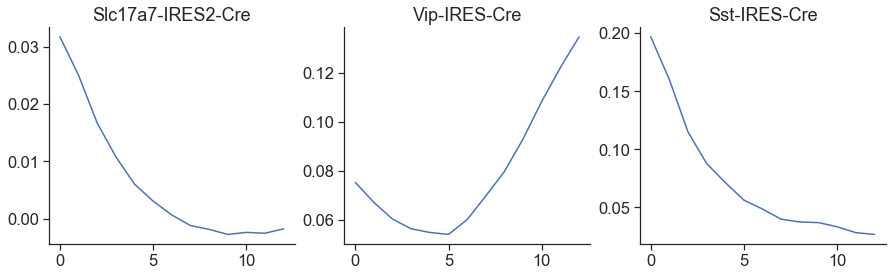

In [12]:
# average omission trace for each cre line
fig, ax = plt.subplots(1,3, figsize=(15,4))
for i,cre_line in enumerate(cre_lines): 
    ax[i].plot(np.nanmean(all_sess_ns_fof_all_cre[cre_line], axis=0))
    ax[i].set_title(cre_line)

### run PCA 

In [13]:
import visual_behavior.clustering.multiscope_fn.def_funs as funs

Running PCA on Slc17a7-IRES2-Cre, matrix size: (12723, 13)
(12723, 7)
Running PCA on Vip-IRES-Cre, matrix size: (3011, 13)
(3011, 5)
Running PCA on Sst-IRES-Cre, matrix size: (1024, 13)
(1024, 6)


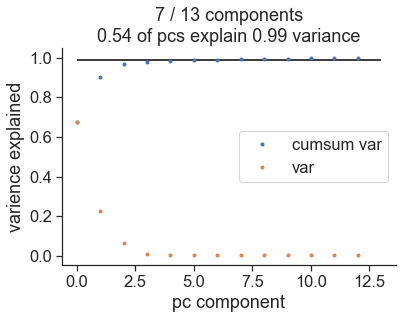

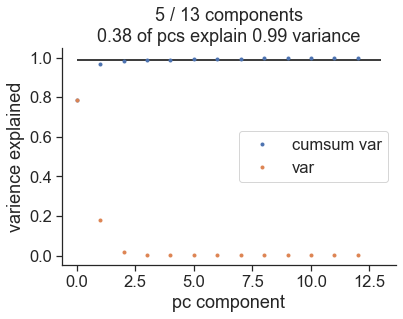

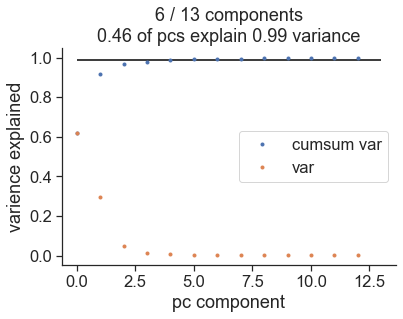

In [15]:
"""
Vars needed here are set in umap_set_vars.py

Here we run umap and pca on the data matrix created in umap_set_vars.py.

After this script run umap_plots.py to make plots.

Created on Mon Jun 29 11:31:25 2020
@author: farzaneh

"""


################################################################################################    
################################################################################################        
#%% Run PCA on all_sess_ns_fof_this_cre
################################################################################################    
################################################################################################    

from sklearn.decomposition import PCA
varexpmax = .99 # 1 # .9

pc_all_cre = {}
pca_variance_all_cre = {}

for cre_line in cre_lines: # icre=0
    all_sess_ns_fof_thisCre = all_sess_ns_fof_all_cre[cre_line] # neurons_allExp_thisCre x 24(frames)
    print(f'Running PCA on {cre_line}, matrix size: {np.shape(all_sess_ns_fof_thisCre)}')

    x_train_pc, pca = funs.doPCA(all_sess_ns_fof_thisCre, varexpmax=varexpmax, doplot=1)
    pca_variance = pca.explained_variance_ratio_
#     x_train_pc.shape

    pc_all_cre[cre_line] = x_train_pc
    pca_variance_all_cre[cre_line] = pca_variance
    
    


### run UMAP

In [16]:
################################################################################################    
################################################################################################    
#%% Run umap on all_sess_ns_fof_thisCre
################################################################################################
################################################################################################

import umap    
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

ncomp = 2 # 3 # number of umap components

embedding_all_cre = {}

for cre_line in cre_lines: # icre = 2    
    all_sess_ns_fof_thisCre = all_sess_ns_fof_all_cre[cre_line] # neurons_allExp_thisCre x 24(frames)
    print(f'Running UMAP on {cre_line}')

    sp = 2
    neigh = 7
    embedding = umap.UMAP(spread= sp, n_neighbors = neigh, n_components = ncomp).fit_transform(all_sess_ns_fof_thisCre)
    print(f'embedding size: {embedding.shape}')
    embedding_all_cre[cre_line] = embedding
    
# embedding_all_cre_3d = copy.deepcopy(embedding_all_cre)

    
    
###########################################################################
#%% After this script, run umap_plot.py to make plots for umap/pca analysis.    
###########################################################################

Running UMAP on Slc17a7-IRES2-Cre
embedding size: (12723, 2)
Running UMAP on Vip-IRES-Cre
embedding size: (3011, 2)
Running UMAP on Sst-IRES-Cre
embedding size: (1024, 2)


### get some things to label with

In [17]:
df['session_number'] = [int(session_number) for session_number in df.session_number.values]

In [18]:
#get image responses for same cells
image_df = multi_session_df.copy()
image_df = image_df[(image_df.engagement_state=='engaged')&(image_df.running==True)&(image_df.omitted==False)]

In [19]:
mean_omission_response = {}
mean_image_response = {}
depth = {}
imaging_depth = {}
targeted_structure = {}
session_number = {}
for cre_line in cre_lines:
    mean_omission_response[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].mean_response.values))
    mean_image_response[cre_line] = np.squeeze(np.vstack(image_df[image_df.cre_line==cre_line].mean_response.values))
    depth[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].depth.values))
    imaging_depth[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].imaging_depth.values))
    session_number[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].session_number.values))
    targeted_structure[cre_line] = np.squeeze(np.vstack(df[df.cre_line==cre_line].targeted_structure.values))


### plots 

#### colored by mean omission response

In [20]:
low_dim_all_cre = embedding_all_cre

c_value = mean_omission_response.copy()
vmin = np.percentile(df.mean_response.values, 5)
vmax = np.percentile(df.mean_response.values, 95)

Text(0, 0.5, 'mean omission response')

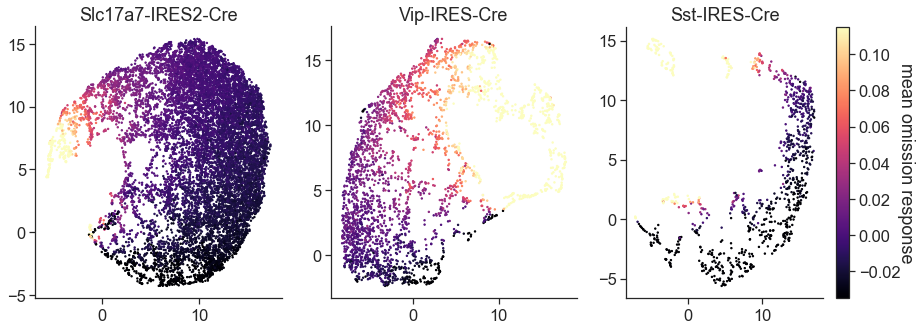

In [21]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, cre_line in enumerate(cre_lines):
    x = low_dim_all_cre[cre_line][:, 0]
    y = low_dim_all_cre[cre_line][:, 1]
    cax = ax[i].scatter(x, y, s=2, label=cre_line, marker='o', c=c_value[cre_line], cmap='magma', vmin=vmin, vmax=vmax)
    ax[i].set_title(cre_line)
cbar = plt.colorbar(cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('mean omission response', rotation=270)

#### colored by mean image response

In [22]:
low_dim_all_cre = embedding_all_cre

c_value = mean_image_response.copy()
vmin = np.percentile(image_df.mean_response.values, 5)
vmax = np.percentile(image_df.mean_response.values, 95)

Text(0, 0.5, 'mean image response')

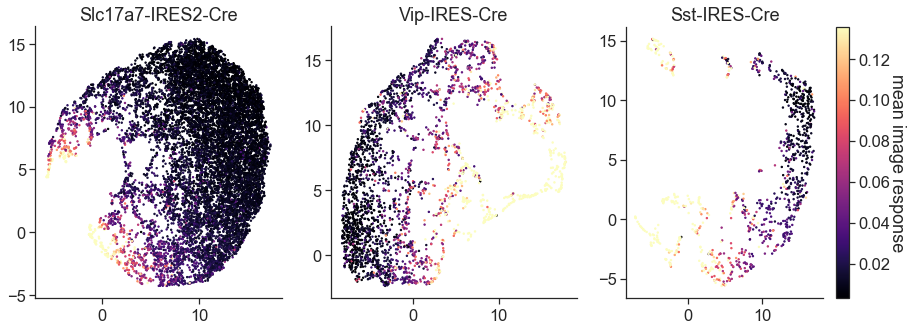

In [23]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, cre_line in enumerate(cre_lines):
    x = low_dim_all_cre[cre_line][:, 0]
    y = low_dim_all_cre[cre_line][:, 1]
    cax = ax[i].scatter(x, y, s=2, label=cre_line, marker='o', c=c_value[cre_line], cmap='magma', vmin=vmin, vmax=vmax)
    ax[i].set_title(cre_line)
cbar = plt.colorbar(cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('mean image response', rotation=270)

why does this look so similar to omission response? confusing...

#### colored by imaging depth

In [24]:
low_dim_all_cre = embedding_all_cre

c_value = imaging_depth.copy()
vmin = np.percentile(df.imaging_depth.values, 5)
vmax = np.percentile(df.imaging_depth.values, 95)

Text(0, 0.5, 'imaging_depth')

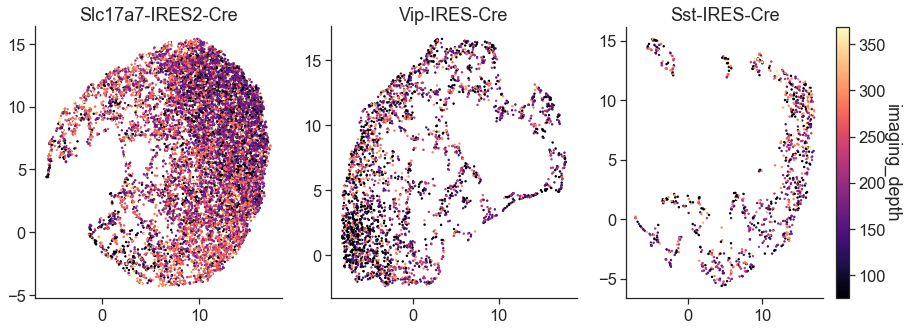

In [25]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, cre_line in enumerate(cre_lines):
    x = low_dim_all_cre[cre_line][:, 0]
    y = low_dim_all_cre[cre_line][:, 1]
    cax = ax[i].scatter(x, y, s=2, label=cre_line, marker='o', c=c_value[cre_line], cmap='magma', vmin=vmin, vmax=vmax)
    ax[i].set_title(cre_line)
cbar = plt.colorbar(cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('imaging_depth', rotation=270)

#### colored by session_number

In [26]:
low_dim_all_cre = embedding_all_cre

c_value = session_number.copy()
vmin = 1
vmax = 6

Text(0, 0.5, 'session_number')

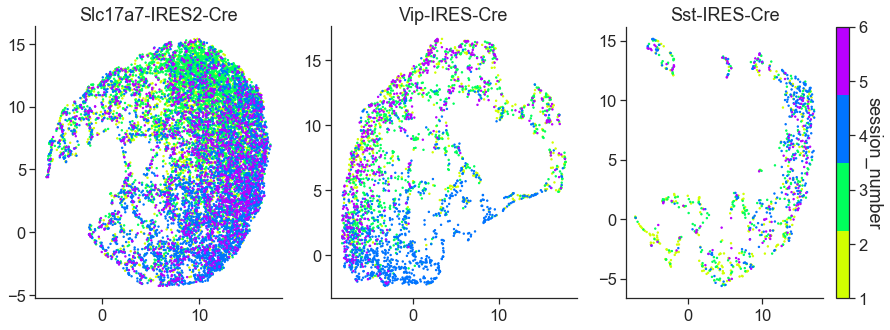

In [27]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette('hsv', 4).as_hex())

fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, cre_line in enumerate(cre_lines):
    x = low_dim_all_cre[cre_line][:, 0]
    y = low_dim_all_cre[cre_line][:, 1]
    cax = ax[i].scatter(x, y, s=2, label=cre_line, marker='o', c=c_value[cre_line], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(cre_line)
cbar = plt.colorbar(cax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('session_number', rotation=270)